# Elementy Inteligencji Obliczeniowej - Sieci Neuronowe


---

**Prowadzący:** Jakub Bednarek<br>
**Kontakt:** jakub.bednarek@put.poznan.pl<br>
**Materiały:** [Strona WWW](http://jakub.bednarek.pracownik.put.poznan.pl)

---

## Uwaga

* **Aby wykonać polecenia należy najpierw przejść do trybu 'playground'. File -> Open in Playground Mode**
* Nowe funkcje Colab pozwalają na autouzupełnianie oraz czytanie dokumentacji

## Cel ćwiczeń:
- zapoznanie się z Keras subclassing API
- stworzenie własnych modeli i warstw z wykorzystaniem Keras subclassing API
- wykorzystanie podstawowych mechanizmów regularyzacji: Dropout i Batch normalization

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np

In [2]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Layer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta, RMSprop
from tensorflow.python.keras import backend as K

In [5]:
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()
x_tr = x_tr[:, :, :, np.newaxis].astype('float32')
x_te = x_te[:, :, :, np.newaxis].astype('float32')
x_te /= 255
x_tr /= 255
x_tr_flat = x_tr.reshape(60000, 784)
x_te_flat = x_te.reshape(10000, 784)
y_tr = to_categorical(y_tr, 10)
y_te = to_categorical(y_te, 10)

## Tworzenie własnych modeli i warstw 
https://www.tensorflow.org/tutorials/customization/custom_layers

https://www.tensorflow.org/guide/keras/custom_layers_and_models

Przykładowy model z warstwami gęstymi dla danych MNIST:

In [6]:
class DenseModel(Model):
  def __init__(self, num_classes=10):
    super().__init__(name='my_model')
    self.num_classes = num_classes
    self.dense_1 = Dense(512, input_shape=(784,), activation='relu')
    self.dense_2 = Dense(512, activation='relu')
    self.dense_3 = Dense(num_classes, activation='softmax')

  def call(self, inputs):
    x = self.dense_1(inputs)
    x = self.dense_2(x)
    x = self.dense_3(x)
    return x

model = DenseModel(num_classes=10)

In [7]:
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_tr_flat, y_tr, batch_size=32, epochs=3)

Epoch 1/3
1875/1875 [==============================] - 19s 10ms/step - loss: 0.3101 - accuracy: 0.9062
Epoch 2/3
1875/1875 [==============================] - 18s 9ms/step - loss: 0.1025 - accuracy: 0.9722
Epoch 3/3
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0830 - accuracy: 0.9796


Przykład własnej warstwy. Warstwa to po prostu funkcjonalny moduł do wielokrotnego używania, podczas gdy model to gotowe rozwiązanie dla danego problemu uczenia maszynowego (tzn. w Kerasie zazwyczaj kompletna sieć neuronowa), które udostępnia dodatkowo takie metody jak `fit`, `evaluate` i `predict`. Oczywiście można też budować modele/warstwy korzystające z innych modeli/warstw, API obu tych klas jest bardzo podobne.

W poniższym kodzie, metoda `build` w `CustomLayer` jest wołana raz przed pierwszym wywołaniem `call` (zaimplementowane jest to w `__call__()`), co pozwala nam uzależnić liczbę wag warstwy od wymiaru wyjść z warstwy poprzedniej. Jeżeli odgórnie wiemy, ile wag ma mieć warstwa, to równie dobrze możemy je zainicjować w `__init__` tak jak wcześniej.

In [8]:
class CustomLayer(Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(CustomLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel',
                                      shape=(int(input_shape[1]), self.output_dim),
                                      initializer='uniform',
                                      trainable=True)

    def call(self, inputs):
        return tf.matmul(inputs, self.kernel)


class CustomModel(Model):

    def __init__(self, num_classes=10):
        super(CustomModel, self).__init__(name='custom_model')
        self.num_classes = num_classes
        # Define your layers here.
        self.dense_1 = CustomLayer(output_dim=512, input_shape=(784,))
        self.dense_2 = CustomLayer(output_dim=512, input_shape=(512,))
        self.dense_3 = CustomLayer(output_dim=num_classes, input_shape=(512,))

    def call(self, inputs):
        # Define your forward pass here,
        # using layers you previously defined (in `__init__`).
        x = self.dense_1(inputs)
        x = K.relu(x)
        x = self.dense_2(x)
        x = K.relu(x)
        x = self.dense_3(x)
        x = K.sigmoid(x)
        return x

model = CustomModel(num_classes=10)
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_tr_flat, y_tr, batch_size=128, epochs=3)

Epoch 1/3
469/469 [==============================] - 8s 15ms/step - loss: 0.5278 - accuracy: 0.8412
Epoch 2/3
469/469 [==============================] - 7s 16ms/step - loss: 0.1033 - accuracy: 0.9689
Epoch 3/3
469/469 [==============================] - 7s 16ms/step - loss: 0.0616 - accuracy: 0.9815


### Zadanie 1
Na podstawie powyższego przykładu stwórz własny model kolejno składający się z:
- warstwy konwolucyjnej (Conv2D): 32 filtry 3x3,
- konwolucyjnej: 64 filtry 3x3,
- warstwy MaxPooling (MaxPooling2D): 2x2
- warstwy ukrytej gęstej (Dense): 128 neuronów,
- warstwy wyjściowej.

Ważne:
- w każdej warstwie poza warstwą wyjściową funkcją aktywacji powinno być relu,
- funkcja aktywacji dla warstwy wyjściowej to softmax,
- między częścią konwolucyjną a gęstą trzeba spłaszczyć tensor przy pomocy warstwy `Flatten`,
- w przykładzie jest wykorzystywana sieć gęsta (dane są spłaszczone), sieci z warstwami konwolucyjnymi muszą otrzymać tensor 4-wymiarowy, zakomentuj linie "spłaszczające" podczas wczytywania danych.
```
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
```

In [36]:
class Model1(Model):
  def __init__(self, num_classes):
    super().__init__(name='MyModel')
    self.num_classes = num_classes
    self.conv_1 = Conv2D(32, (3, 3), activation='relu')
    self.conv_2 = Conv2D(64, (3, 3), activation='relu')
    self.pool_1 = MaxPooling2D()
    self.flatten = Flatten()
    self.dense_1 = Dense(128, activation='relu')
    self.dense_2 = Dense(num_classes, activation='softmax')

  def call(self, inputs):
    x = self.conv_1(inputs)
    x = self.conv_2(x)
    x = self.pool_1(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.dense_2(x)
    return x

model1 = Model1(num_classes=10)
model1.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
model1_history = model1.fit(x_tr, y_tr, batch_size=32, epochs=10, validation_data=(x_te, y_te))

Epoch 1/10
1875/1875 [==============================] - 162s 86ms/step - loss: 0.2358 - accuracy: 0.9267 - val_loss: 0.0396 - val_accuracy: 0.9867
Epoch 2/10
1875/1875 [==============================] - 160s 86ms/step - loss: 0.0419 - accuracy: 0.9870 - val_loss: 0.0442 - val_accuracy: 0.9871
Epoch 3/10
1875/1875 [==============================] - 161s 86ms/step - loss: 0.0269 - accuracy: 0.9922 - val_loss: 0.0397 - val_accuracy: 0.9882
Epoch 4/10
1875/1875 [==============================] - 159s 85ms/step - loss: 0.0223 - accuracy: 0.9938 - val_loss: 0.0357 - val_accuracy: 0.9897
Epoch 5/10
1875/1875 [==============================] - 160s 85ms/step - loss: 0.0155 - accuracy: 0.9955 - val_loss: 0.0424 - val_accuracy: 0.9890
Epoch 6/10
1875/1875 [==============================] - 159s 85ms/step - loss: 0.0144 - accuracy: 0.9963 - val_loss: 0.0525 - val_accuracy: 0.9869
Epoch 7/10
1875/1875 [==============================] - 160s 85ms/step - loss: 0.0104 - accuracy: 0.9970 - val_loss: 0

### Zadanie 2 
Na podstawie powyższego przykładu stwórz model bloku ResNet:
- w warstwach konwolucyjnych wykorzystaj padding='same', aby rozmiary tensorów się nie zmieniały,
- tego modelu nie trzeba budować i uczyć, zostanie on wykorzystany w kolejnym zadaniu.

![resnet](https://miro.medium.com/max/1000/1*6HDuqhUzP92iXhHoS0Wl3w.png)

In [12]:
class ResBlock(Model):
  def __init__(self):
    super().__init__(name='ResBlock')
    self.conv_1 = Conv2D(64, (3, 3), padding='same', activation='relu')
    self.conv_2 = Conv2D(64, (3, 3), padding='same')

  def call(self, inputs):
    x = self.conv_1(inputs)
    x = self.conv_2(x)
    x = x + inputs
    x = K.relu(x)
    return x

### Zadanie 3
Zmodyfikuj model z zadania 1, zamieniając warstwy konwolucyjne na dwa modele bloku ResNet z zadania 2.

In [39]:
class ResNet(Model):
  def __init__(self, num_classes):
    super().__init__(name='ResNet')
    self.num_classes = num_classes
    self.res_1 = ResBlock()
    self.res_2 = ResBlock()
    self.pool_1 = MaxPooling2D()
    self.flatten = Flatten()
    self.dense_1 = Dense(128, activation='relu')
    self.dense_2 = Dense(num_classes, activation='softmax')

  def call(self, inputs):
    x = self.res_1(inputs)
    x = self.res_2(x)
    x = self.pool_1(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.dense_2(x)
    return x

resnet = ResNet(num_classes=10)
resnet.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
resnet.fit(x_tr, y_tr, batch_size=32, epochs=10, validation_data=(x_te, y_te))

Epoch 1/10
1875/1875 [==============================] - 888s 473ms/step - loss: 0.3119 - accuracy: 0.9218 - val_loss: 0.0359 - val_accuracy: 0.9881
Epoch 2/10
1875/1875 [==============================] - 886s 473ms/step - loss: 0.0427 - accuracy: 0.9871 - val_loss: 0.0585 - val_accuracy: 0.9813
Epoch 3/10
1875/1875 [==============================] - 887s 473ms/step - loss: 0.0329 - accuracy: 0.9903 - val_loss: 0.0458 - val_accuracy: 0.9874
Epoch 4/10
1875/1875 [==============================] - 886s 472ms/step - loss: 0.0282 - accuracy: 0.9918 - val_loss: 0.0501 - val_accuracy: 0.9881
Epoch 5/10
1875/1875 [==============================] - 885s 472ms/step - loss: 0.0248 - accuracy: 0.9934 - val_loss: 0.0450 - val_accuracy: 0.9865
Epoch 6/10
1875/1875 [==============================] - 882s 471ms/step - loss: 0.0251 - accuracy: 0.9940 - val_loss: 0.0336 - val_accuracy: 0.9904
Epoch 7/10
1875/1875 [==============================] - 885s 472ms/step - loss: 0.0209 - accuracy: 0.9949 - val_

### Zadanie 4
Wykorzystując Keras Subclassing API, napisz Autoenkoder dla zbioru danych MNIST.
- stwórz osobny model Enkodera,
- stwórz osobny model Dekodera,
- połącz oba modele celem zbudowania Autoenkodera,
- można korzystać z warstw gęstych, nie trzeba korzystać z konwolucji,
- poprzednie zadania były przykładem klasyfikacji, w których wykorzystywana była funkcja błędu categorical_crossentropy (która jest stosowana dla wektorów reprezentujących rozkład prawdopodobieństwa), w przypadku Autoenkoderów model rekonstruuje dane wejściowe, więc najłatwiej wykorzystać mean square error (mse),
- w związku z powyższym również wyjście sieci się różni, nie klasyfikujemy (y_train) tylko rekonstruujemy (x_train)

https://blog.keras.io/building-autoencoders-in-keras.html

In [40]:
class Encoder(Model):
  def __init__(self):
    super().__init__(name='Encoder')
    self.dense_1 = Dense(128, activation='relu')
    self.dense_2 = Dense(64, activation='relu')
    self.dense_3 = Dense(32, activation='relu')

  def call(self, inputs):
    x = self.dense_1(inputs)
    x = self.dense_2(x)
    x = self.dense_3(x)
    return x

class Decoder(Model):
  def __init__(self):
    super().__init__(name='Decoder')
    self.dense_1 = Dense(64, activation='relu')
    self.dense_2 = Dense(128, activation='relu')
    self.dense_3 = Dense(784, activation='sigmoid')

  def call(self, inputs):
    x = self.dense_1(inputs)
    x = self.dense_2(x)
    x = self.dense_3(x)
    return x

class Autoencoder(Model):
  def __init__(self):
    super().__init__(name='Autoencoder')
    self.encoder = Encoder()
    self.decoder = Decoder()

  def call(self, inputs):
    x = self.encoder(inputs)
    x = self.decoder(x)
    return x

autoencoder = Autoencoder()
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(x_tr_flat, x_tr_flat, batch_size=256, epochs=5, shuffle=True, validation_data=(x_te_flat, x_te_flat))

Epoch 1/5
235/235 [==============================] - 3s 12ms/step - loss: 0.0957 - val_loss: 0.0368
Epoch 2/5
235/235 [==============================] - 3s 12ms/step - loss: 0.0337 - val_loss: 0.0260
Epoch 3/5
235/235 [==============================] - 3s 12ms/step - loss: 0.0252 - val_loss: 0.0219
Epoch 4/5
235/235 [==============================] - 3s 12ms/step - loss: 0.0217 - val_loss: 0.0197
Epoch 5/5
235/235 [==============================] - 3s 12ms/step - loss: 0.0195 - val_loss: 0.0176


## Regularyzacja
### Zadanie 5
Rozszerz model stworzony w zadaniu 1 o dwie warstwy Dropout (Dropout - https://keras.io/api/layers/regularization_layers/dropout/):
- jedna po warstwie MaxPooling (wartość współczynnika odrzucenia 0.25)
- druga po gęstej warstwie ukrytej (Dense), wartość współczynnika odrzucenia 0.5.

  





In [26]:
class Model2(Model):
  def __init__(self, num_classes):
    super().__init__(name='MyModelReg')
    self.num_classes = num_classes
    self.conv_1 = Conv2D(32, (3,3), activation='relu')
    self.conv_2 = Conv2D(64, (3,3), activation='relu')
    self.pool_1 = MaxPooling2D()
    self.dropout_1 = Dropout(0.25)
    self.flatten = Flatten()
    self.dense_1 = Dense(128, activation='relu')
    self.dropout_2 = Dropout(0.5)
    self.dense_2 = Dense(num_classes, activation='softmax')

  def call(self, inputs, training=None):
    x = self.conv_1(inputs)
    x = self.conv_2(x)
    x = self.pool_1(x)
    x = self.dropout_1(x, training=training)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.dropout_2(x, training=training)
    x = self.dense_2(x)
    return x

model2 = Model2(num_classes=10)
model2.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
model2_history = model2.fit(x_tr, y_tr, batch_size=32, epochs=10, validation_data=(x_te, y_te))

Epoch 1/10
1875/1875 [==============================] - 167s 89ms/step - loss: 0.3410 - accuracy: 0.8928 - val_loss: 0.0674 - val_accuracy: 0.9786
Epoch 2/10
1875/1875 [==============================] - 165s 88ms/step - loss: 0.0917 - accuracy: 0.9741 - val_loss: 0.0525 - val_accuracy: 0.9835
Epoch 3/10
1875/1875 [==============================] - 164s 87ms/step - loss: 0.0782 - accuracy: 0.9786 - val_loss: 0.0571 - val_accuracy: 0.9832
Epoch 4/10
1875/1875 [==============================] - 164s 88ms/step - loss: 0.0794 - accuracy: 0.9780 - val_loss: 0.0472 - val_accuracy: 0.9850
Epoch 5/10
1875/1875 [==============================] - 165s 88ms/step - loss: 0.0831 - accuracy: 0.9775 - val_loss: 0.0596 - val_accuracy: 0.9818
Epoch 6/10
1875/1875 [==============================] - 165s 88ms/step - loss: 0.0828 - accuracy: 0.9774 - val_loss: 0.0483 - val_accuracy: 0.9855
Epoch 7/10
1875/1875 [==============================] - 166s 88ms/step - loss: 0.0848 - accuracy: 0.9766 - val_loss: 0

### Zadanie 6
Rozszerz model stworzony w zadaniu 1 o dwie warstwy Batch normalization (BatchNormalization - https://keras.io/layers/normalization/) po warstwach konwolucyjnych.

In [25]:
class Model3(Model):
  def __init__(self, num_classes):
    super().__init__(name='MyModelBatchNorm')
    self.num_classes = num_classes
    self.conv_1 = Conv2D(32, (3, 3), activation='relu')
    self.batch_norm_1 = BatchNormalization()
    self.conv_2 = Conv2D(64, (3, 3), activation='relu')
    self.batch_norm_2 = BatchNormalization()
    self.pool_1 = MaxPooling2D()
    self.flatten = Flatten()
    self.dense_1 = Dense(128, activation='relu')
    self.dense_2 = Dense(num_classes, activation='softmax')

  def call(self, inputs, training=None):
    x = self.conv_1(inputs)
    x = self.batch_norm_1(x, training=training)
    x = self.conv_2(x)
    x = self.batch_norm_2(x, training=training)
    x = self.pool_1(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    return self.dense_2(x)

model3 = Model3(num_classes=10)
model3.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
model3_history = model3.fit(x_tr, y_tr, batch_size=32, epochs=10, validation_data=(x_te, y_te))

Epoch 1/10
1875/1875 [==============================] - 196s 104ms/step - loss: 0.4794 - accuracy: 0.9209 - val_loss: 0.1421 - val_accuracy: 0.9757
Epoch 2/10
1875/1875 [==============================] - 194s 103ms/step - loss: 0.0924 - accuracy: 0.9827 - val_loss: 0.1419 - val_accuracy: 0.9804
Epoch 3/10
1875/1875 [==============================] - 194s 104ms/step - loss: 0.0563 - accuracy: 0.9890 - val_loss: 0.1323 - val_accuracy: 0.9830
Epoch 4/10
1875/1875 [==============================] - 194s 103ms/step - loss: 0.0406 - accuracy: 0.9925 - val_loss: 0.0858 - val_accuracy: 0.9858
Epoch 5/10
1875/1875 [==============================] - 194s 103ms/step - loss: 0.0228 - accuracy: 0.9952 - val_loss: 0.1060 - val_accuracy: 0.9837
Epoch 6/10
1875/1875 [==============================] - 196s 104ms/step - loss: 0.0202 - accuracy: 0.9960 - val_loss: 0.0930 - val_accuracy: 0.9872
Epoch 7/10
1875/1875 [==============================] - 194s 103ms/step - loss: 0.0118 - accuracy: 0.9971 - val_

### Zadanie 7
Rozszerz model stworzony w zadaniu 1 o warstwy z zadań 5 i 6.

In [24]:
class Model4(Model):
  def __init__(self, num_classes):
    super().__init__(name='MyModelRegBatchNorm')
    self.num_classes = num_classes
    self.conv_1 = Conv2D(32, (3, 3), activation='relu')
    self.batch_norm_1 = BatchNormalization()
    self.conv_2 = Conv2D(64, (3, 3), activation='relu')
    self.batch_norm_2 = BatchNormalization()
    self.pool_1 = MaxPooling2D()
    self.dropout_1 = Dropout(0.25)
    self.flatten = Flatten()
    self.dense_1 = Dense(128, activation='relu')
    self.dropout_2 = Dropout(0.5)
    self.dense_2 = Dense(num_classes, activation='softmax')


  def call(self, inputs, training=None):
    x = self.conv_1(inputs)
    x = self.batch_norm_1(x, training=training)
    x = self.conv_2(x)
    x = self.batch_norm_2(x, training=training)
    x = self.pool_1(x)
    x = self.dropout_1(x, training=training)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.dropout_2(x, training=training)
    x = self.dense_2(x)
    return x

model4 = Model4(num_classes=10)
model4.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
model4_history = model4.fit(x_tr, y_tr, batch_size=32, epochs=10, validation_data=(x_te, y_te))

Epoch 1/10
1875/1875 [==============================] - 204s 108ms/step - loss: 0.7279 - accuracy: 0.8451 - val_loss: 0.0984 - val_accuracy: 0.9775
Epoch 2/10
1875/1875 [==============================] - 202s 108ms/step - loss: 0.2318 - accuracy: 0.9532 - val_loss: 0.1319 - val_accuracy: 0.9730
Epoch 3/10
1875/1875 [==============================] - 205s 109ms/step - loss: 0.1871 - accuracy: 0.9599 - val_loss: 0.0745 - val_accuracy: 0.9816
Epoch 4/10
1875/1875 [==============================] - 204s 109ms/step - loss: 0.1678 - accuracy: 0.9657 - val_loss: 0.0795 - val_accuracy: 0.9823
Epoch 5/10
1875/1875 [==============================] - 202s 108ms/step - loss: 0.1432 - accuracy: 0.9682 - val_loss: 0.0635 - val_accuracy: 0.9855
Epoch 6/10
1875/1875 [==============================] - 202s 108ms/step - loss: 0.1252 - accuracy: 0.9720 - val_loss: 0.0546 - val_accuracy: 0.9866
Epoch 7/10
1875/1875 [==============================] - 202s 108ms/step - loss: 0.1162 - accuracy: 0.9719 - val_

### Zadanie 8 
Porównaj modele stworzone w zadaniach 1, 5, 6, 7 na zbiorze danych MNIST. Stwórz wykresy z przebiegiem błędu funkcji celu i trafności klasyfikacji dla zbioru treningowego i walidacyjnego.
Cztery wykresy:
- błąd funkcji celu dla zbioru treningowego,
- błąd funkcji celu dla zbioru walidacyjnego,
- trafność klasyfikacji dla zbioru treningowego,
- trafność klasyfikacji dla zbioru walidacyjnego

Na każdym wykresie powinny być 4 przebiegi dla modeli z wszystkich zadań (1, 5, 6, 7), tak by łatwo można je było ze sobą wizualnie porównać.


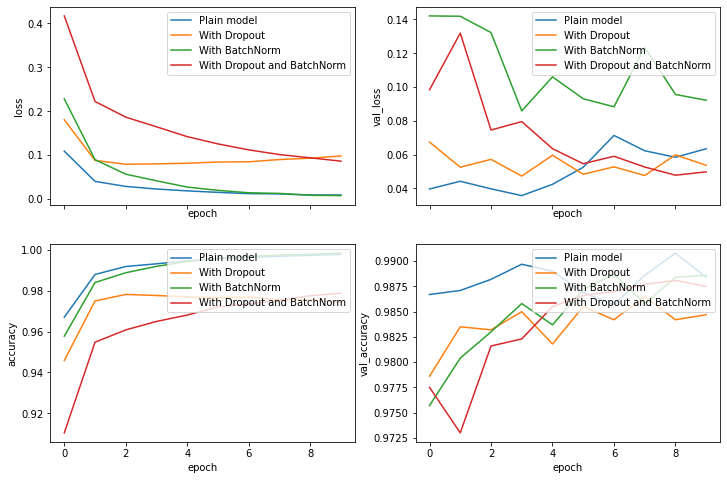

In [37]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), sharex=True)
params = 'loss', 'val_loss', 'accuracy', 'val_accuracy'
for ax, param in zip(axs.reshape(-1), params):
  ax.plot(model1_history.history[param])
  ax.plot(model2_history.history[param])
  ax.plot(model3_history.history[param])
  ax.plot(model4_history.history[param])
  ax.set_ylabel(param)
  ax.set_xlabel('epoch')
  ax.legend(['Plain model', 'With Dropout', 'With BatchNorm', 'With Dropout and BatchNorm'], loc='upper right')

plt.show()